In [1]:
import sys
import os
current_dir = os.getcwd()  #use to import the defined functions
parent_dir = os.path.dirname(current_dir) 
sys.path.append(parent_dir)  

"""
incase the above code does not work, you can use the absolute path instead
sys.path.append(r".\")
"""


'\nincase the above code does not work, you can use the absolute path instead\nsys.path.append(r".")\n'

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 

from utils.plot_utils import plot_kde_2d
from utils.basic_utils import setup_seed, sample_noise
from data.SimulationData import DataGenerator, generate_multi_responses_multiY
from utils.training_utils_copy import train_WGR_fnn
from utils.evaluation_utils import L1L2_MSE_mean_sd_G, MSE_quantile_G_multiY
from models.generator import generator_fnn
from models.discriminator import discriminator_fnn



In [3]:
import argparse


if 'ipykernel_launcher.py' in sys.argv[0]:  #if not work in jupyter, you can delete this part
    import sys
    sys.argv = [sys.argv[0]] 


parser = argparse.ArgumentParser(description='Implementation of WGR for M1')

parser.add_argument('--Xdim', default=1, type=int, help='dimensionality of X')
parser.add_argument('--Ydim', default=2, type=int, help='dimensionality of Y')
parser.add_argument('--model', default='M4', type=str, help='model')

parser.add_argument('--noise_dim', default=10, type=int, help='dimensionality of noise vector')
parser.add_argument('--noise_dist', default='gaussian', type=str, help='distribution of noise vector')

parser.add_argument('--train', default=5000, type=int, help='size of train dataset')
parser.add_argument('--val', default=1000, type=int, help='size of validation dataset')
parser.add_argument('--test', default=1000, type=int, help='size of test dataset')

parser.add_argument('--train_batch', default=128, type=int, metavar='BS', help='batch size while training')
parser.add_argument('--val_batch', default=100, type=int, metavar='BS', help='batch size while validation')
parser.add_argument('--test_batch', default=100, type=int, metavar='BS', help='batch size while testing')
parser.add_argument('--epochs', default=100, type=int, help='number of epochs to train')
parser.add_argument('--reps', default=100, type=int, help='number of replications')

args = parser.parse_args()

print(args)

Namespace(Xdim=1, Ydim=2, model='M4', noise_dim=10, noise_dist='gaussian', train=5000, val=1000, test=1000, train_batch=128, val_batch=100, test_batch=100, epochs=100, reps=100)


In [4]:
setup_seed(5678)

In [5]:
# Generate data from M3
data_gen = DataGenerator(args)
DATA = data_gen.generate_data(args.model)

train_X, train_Y = DATA['train_X'], DATA['train_Y']
val_X, val_Y = DATA['val_X'], DATA['val_Y']
test_X, test_Y = DATA['test_X'], DATA['test_Y']

In [6]:
# Create TensorDatasets and initialize a DataLoaders
train_dataset = TensorDataset( train_X.float(), train_Y.float() )
loader_train = DataLoader(train_dataset , batch_size=args.train_batch, shuffle=True)

val_dataset = TensorDataset( val_X.float(), val_Y.float() )
loader_val = DataLoader(val_dataset , batch_size=args.val_batch, shuffle=True)

test_dataset = TensorDataset( test_X.float(), test_Y.float() )
loader_test  = DataLoader(test_dataset , batch_size=args.test_batch, shuffle=True)

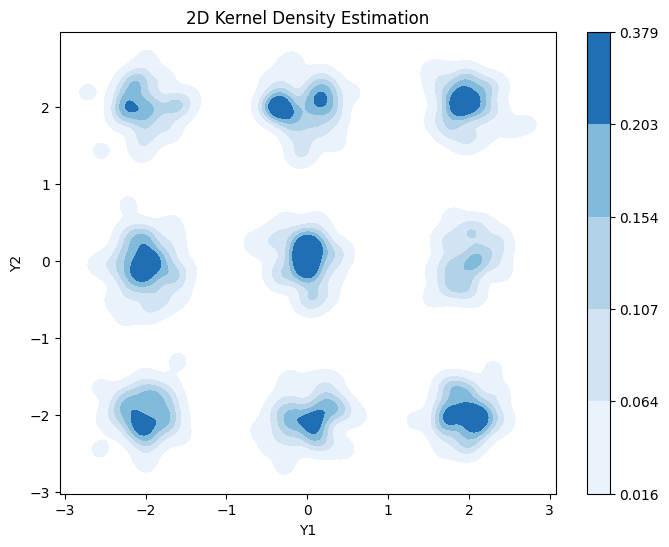

In [7]:
# Generate multiple response samples for visualization of the conditional distribution
# - Takes the first training sample and uses it as the conditioning value
plot_Y = generate_multi_responses_multiY(x_value = train_X[1].view([1]).item(), n_responses=500,model_type=args.model)
# Create a 2D kernel density estimation plot to visualize the distribution of responses
fig, ax = plot_kde_2d(plot_Y, title="2D Kernel Density Estimation")
plt.show()
plt.close()

In [8]:
# Define generator network and discriminator network
G_net = generator_fnn(Xdim=args.Xdim, Ydim=args.Ydim, noise_dim=args.noise_dim, hidden_dims = [512, 512, 512])
D_net = discriminator_fnn(input_dim=args.Xdim+args.Ydim, hidden_dims = [512, 512, 512])

In [9]:
D_solver = optim.RMSprop(D_net.parameters(),lr = 0.0002)
G_solver = optim.RMSprop(G_net.parameters(),lr = 0.0002)

Mean L1 Loss per dimension: tensor([1.6722, 1.6438])
Mean L2 Loss per dimension: tensor([3.9168, 3.7445])
Epoch 0 - D Loss: 1.5469, G Loss: 1.7741
Epoch 1 - D Loss: 0.6968, G Loss: 2.2508
Epoch 2 - D Loss: 0.2651, G Loss: 2.5947
Epoch 3 - D Loss: 0.3438, G Loss: 3.0770
Epoch 4 - D Loss: 0.3703, G Loss: 3.2938
Epoch 5 - D Loss: 0.4101, G Loss: 3.6453
Epoch 6 - D Loss: 0.4008, G Loss: 3.8443
Epoch 7 - D Loss: 0.3963, G Loss: 3.9656
Epoch 8 - D Loss: 0.3442, G Loss: 4.0877
Epoch 9 - D Loss: 0.3758, G Loss: 4.1441
Epoch 10 - D Loss: 0.3252, G Loss: 4.1670
Epoch 11 - D Loss: 0.3258, G Loss: 4.1504
Epoch 12 - D Loss: 0.3194, G Loss: 4.0788
Epoch 13 - D Loss: 0.2844, G Loss: 4.0438
Epoch 14 - D Loss: 0.2787, G Loss: 3.9925
Epoch 15 - D Loss: 0.2433, G Loss: 3.9672
Epoch 16 - D Loss: 0.2120, G Loss: 3.8522
Epoch 17 - D Loss: 0.2158, G Loss: 3.8476
Epoch 18 - D Loss: 0.2053, G Loss: 3.8033
Epoch 19 - D Loss: 0.1881, G Loss: 3.7843
Epoch 20 - D Loss: 0.1774, G Loss: 3.7726
Epoch 21 - D Loss: 0.1

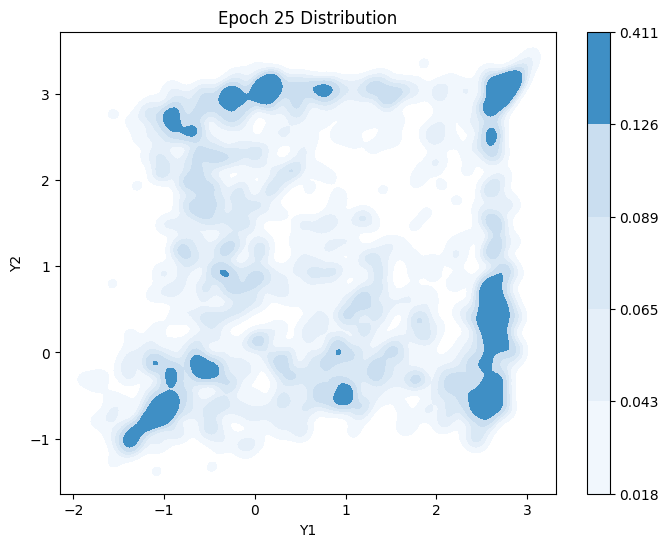

New best multivariate model with L2: 2.8574
Epoch 25 - D Loss: 0.1447, G Loss: 3.4438
Mean L1 Loss per dimension: tensor([1.4625, 1.4620])
Mean L2 Loss per dimension: tensor([2.8706, 2.8775])
Epoch 26, Iter 1050, D Loss: 0.1387, G Loss: 3.4496, L1: 1.4623, L2: 2.8740
Epoch 26 - D Loss: 0.1371, G Loss: 3.4444
Epoch 27 - D Loss: 0.1350, G Loss: 3.4038
Mean L1 Loss per dimension: tensor([1.4613, 1.4319])
Mean L2 Loss per dimension: tensor([2.8768, 2.7869])
Epoch 28, Iter 1100, D Loss: 0.1289, G Loss: 3.3570, L1: 1.4466, L2: 2.8318
New best multivariate model with L2: 2.8318
Epoch 28 - D Loss: 0.1276, G Loss: 3.3548
Mean L1 Loss per dimension: tensor([1.4624, 1.4731])
Mean L2 Loss per dimension: tensor([2.8834, 2.9066])
Epoch 29, Iter 1150, D Loss: 0.1552, G Loss: 3.2982, L1: 1.4678, L2: 2.8950
Epoch 29 - D Loss: 0.1465, G Loss: 3.2999
Mean L1 Loss per dimension: tensor([1.4376, 1.4408])
Mean L2 Loss per dimension: tensor([2.8086, 2.8184])
Epoch 30, Iter 1200, D Loss: 0.1172, G Loss: 3.286

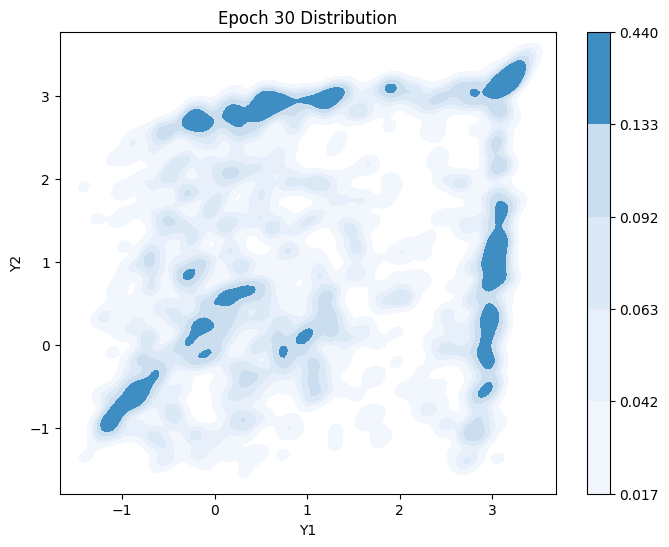

New best multivariate model with L2: 2.8135
Epoch 30 - D Loss: 0.1229, G Loss: 3.2877
Epoch 31 - D Loss: 0.1153, G Loss: 3.2591
Mean L1 Loss per dimension: tensor([1.4404, 1.4545])
Mean L2 Loss per dimension: tensor([2.8305, 2.8561])
Epoch 32, Iter 1250, D Loss: 0.1481, G Loss: 3.1978, L1: 1.4475, L2: 2.8433
Epoch 32 - D Loss: 0.1315, G Loss: 3.2419
Mean L1 Loss per dimension: tensor([1.4450, 1.4451])
Mean L2 Loss per dimension: tensor([2.8186, 2.8334])
Epoch 33, Iter 1300, D Loss: 0.1103, G Loss: 3.2001, L1: 1.4450, L2: 2.8260
Epoch 33 - D Loss: 0.1108, G Loss: 3.2099
Mean L1 Loss per dimension: tensor([1.4544, 1.4569])
Mean L2 Loss per dimension: tensor([2.8634, 2.8500])
Epoch 34, Iter 1350, D Loss: 0.1200, G Loss: 3.1431, L1: 1.4557, L2: 2.8567
Epoch 34 - D Loss: 0.1195, G Loss: 3.1440
Mean L1 Loss per dimension: tensor([1.4499, 1.4251])
Mean L2 Loss per dimension: tensor([2.8567, 2.7640])
Epoch 35, Iter 1400, D Loss: 0.1282, G Loss: 3.0962, L1: 1.4375, L2: 2.8104


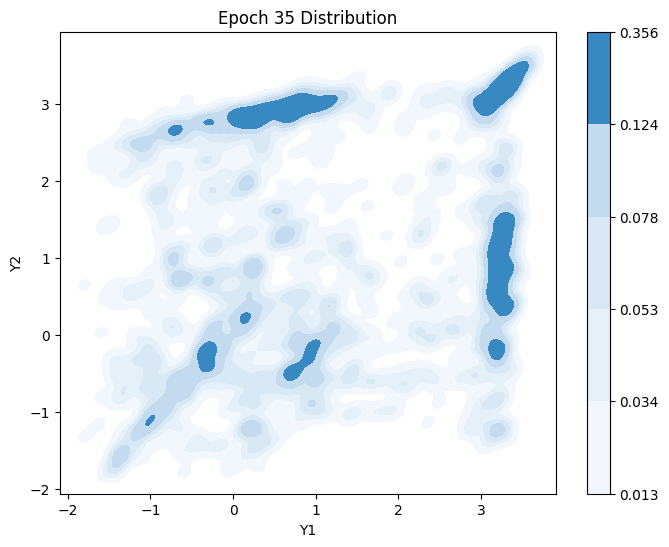

New best multivariate model with L2: 2.8104
Epoch 35 - D Loss: 0.1249, G Loss: 3.1021
Epoch 36 - D Loss: 0.1121, G Loss: 3.0883
Mean L1 Loss per dimension: tensor([1.4693, 1.4484])
Mean L2 Loss per dimension: tensor([2.9044, 2.8327])
Epoch 37, Iter 1450, D Loss: 0.1028, G Loss: 3.0879, L1: 1.4588, L2: 2.8686
Epoch 37 - D Loss: 0.1145, G Loss: 3.0853
Mean L1 Loss per dimension: tensor([1.4526, 1.4418])
Mean L2 Loss per dimension: tensor([2.8586, 2.8183])
Epoch 38, Iter 1500, D Loss: 0.1017, G Loss: 3.0790, L1: 1.4472, L2: 2.8384
Epoch 38 - D Loss: 0.1129, G Loss: 3.0932
Mean L1 Loss per dimension: tensor([1.4608, 1.4429])
Mean L2 Loss per dimension: tensor([2.8850, 2.8223])
Epoch 39, Iter 1550, D Loss: 0.1021, G Loss: 3.0890, L1: 1.4519, L2: 2.8536
Epoch 39 - D Loss: 0.0983, G Loss: 3.0713
Epoch 40 - D Loss: 0.1090, G Loss: 3.0281
Mean L1 Loss per dimension: tensor([1.4461, 1.4376])
Mean L2 Loss per dimension: tensor([2.8426, 2.7906])
Epoch 41, Iter 1600, D Loss: 0.1325, G Loss: 3.1343,

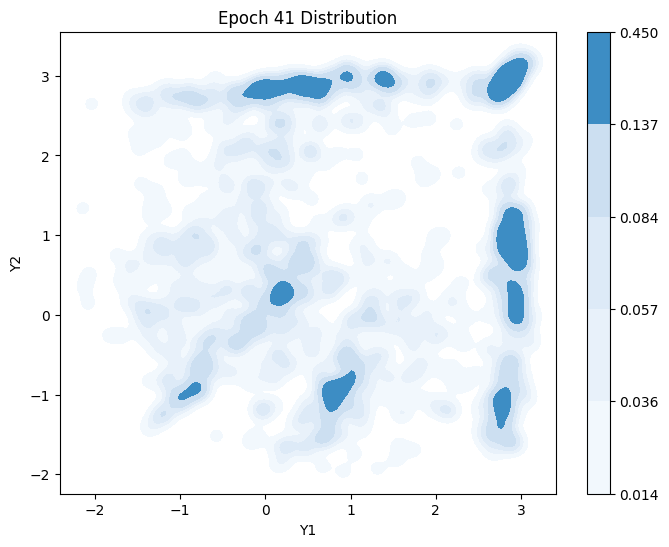

Epoch 41 - D Loss: 0.1001, G Loss: 3.0151
Mean L1 Loss per dimension: tensor([1.4460, 1.4495])
Mean L2 Loss per dimension: tensor([2.8481, 2.8214])
Epoch 42, Iter 1650, D Loss: 0.1139, G Loss: 2.9931, L1: 1.4478, L2: 2.8347
Epoch 42 - D Loss: 0.1057, G Loss: 3.0051
Mean L1 Loss per dimension: tensor([1.4335, 1.4326])
Mean L2 Loss per dimension: tensor([2.8048, 2.7851])
Epoch 43, Iter 1700, D Loss: 0.0942, G Loss: 2.9929, L1: 1.4330, L2: 2.7950
New best multivariate model with L2: 2.7950
Epoch 43 - D Loss: 0.0924, G Loss: 2.9849
Mean L1 Loss per dimension: tensor([1.4427, 1.4259])
Mean L2 Loss per dimension: tensor([2.8427, 2.7874])
Epoch 44, Iter 1750, D Loss: 0.0917, G Loss: 2.9705, L1: 1.4343, L2: 2.8151
Epoch 44 - D Loss: 0.0939, G Loss: 2.9785
Epoch 45 - D Loss: 0.0950, G Loss: 2.9911
Mean L1 Loss per dimension: tensor([1.4455, 1.4205])
Mean L2 Loss per dimension: tensor([2.8491, 2.7506])
Epoch 46, Iter 1800, D Loss: 0.1172, G Loss: 2.9320, L1: 1.4330, L2: 2.7998


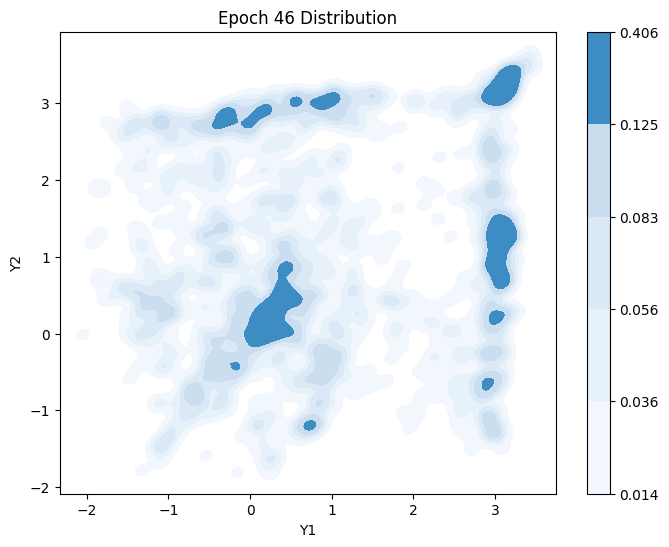

Epoch 46 - D Loss: 0.1038, G Loss: 2.9358
Mean L1 Loss per dimension: tensor([1.4465, 1.4788])
Mean L2 Loss per dimension: tensor([2.8402, 2.9362])
Epoch 47, Iter 1850, D Loss: 0.0944, G Loss: 2.8856, L1: 1.4627, L2: 2.8882
Epoch 47 - D Loss: 0.0922, G Loss: 2.9172
Mean L1 Loss per dimension: tensor([1.4449, 1.4445])
Mean L2 Loss per dimension: tensor([2.8522, 2.8032])
Epoch 48, Iter 1900, D Loss: 0.0860, G Loss: 2.9083, L1: 1.4447, L2: 2.8277
Epoch 48 - D Loss: 0.0839, G Loss: 2.9107
Mean L1 Loss per dimension: tensor([1.4421, 1.4370])
Mean L2 Loss per dimension: tensor([2.8278, 2.7850])
Epoch 49, Iter 1950, D Loss: 0.0816, G Loss: 2.8945, L1: 1.4395, L2: 2.8064
Epoch 49 - D Loss: 0.0816, G Loss: 2.8945
Epoch 50 - D Loss: 0.0935, G Loss: 2.8729
Mean L1 Loss per dimension: tensor([1.4390, 1.4468])
Mean L2 Loss per dimension: tensor([2.8141, 2.8286])
Epoch 51, Iter 2000, D Loss: 0.0770, G Loss: 2.8245, L1: 1.4429, L2: 2.8213


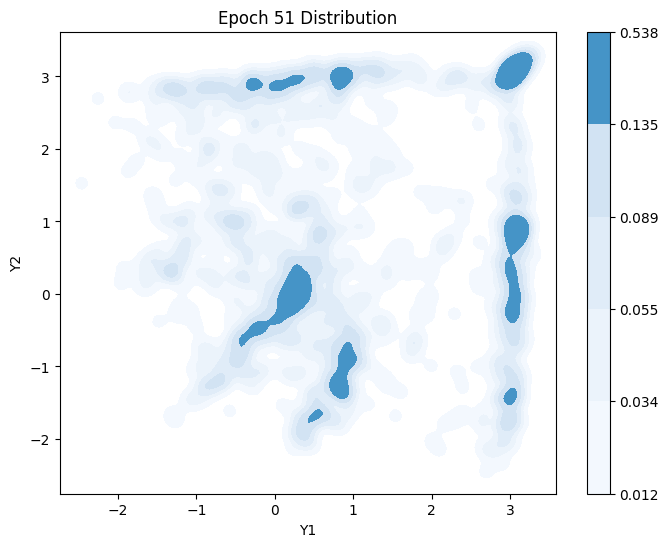

Epoch 51 - D Loss: 0.0864, G Loss: 2.8266
Mean L1 Loss per dimension: tensor([1.4470, 1.4639])
Mean L2 Loss per dimension: tensor([2.8479, 2.8845])
Epoch 52, Iter 2050, D Loss: 0.0783, G Loss: 2.8557, L1: 1.4554, L2: 2.8662
Epoch 52 - D Loss: 0.0809, G Loss: 2.8473
Mean L1 Loss per dimension: tensor([1.4475, 1.4753])
Mean L2 Loss per dimension: tensor([2.8547, 2.9393])
Epoch 53, Iter 2100, D Loss: 0.0770, G Loss: 2.8200, L1: 1.4614, L2: 2.8970
Epoch 53 - D Loss: 0.0775, G Loss: 2.8312
Epoch 54 - D Loss: 0.0814, G Loss: 2.7785
Mean L1 Loss per dimension: tensor([1.4568, 1.4525])
Mean L2 Loss per dimension: tensor([2.8777, 2.8511])
Epoch 55, Iter 2150, D Loss: 0.0713, G Loss: 2.8047, L1: 1.4546, L2: 2.8644
Epoch 55 - D Loss: 0.0773, G Loss: 2.7943
Mean L1 Loss per dimension: tensor([1.4373, 1.4504])
Mean L2 Loss per dimension: tensor([2.8193, 2.8488])
Epoch 56, Iter 2200, D Loss: 0.0749, G Loss: 2.7661, L1: 1.4439, L2: 2.8340


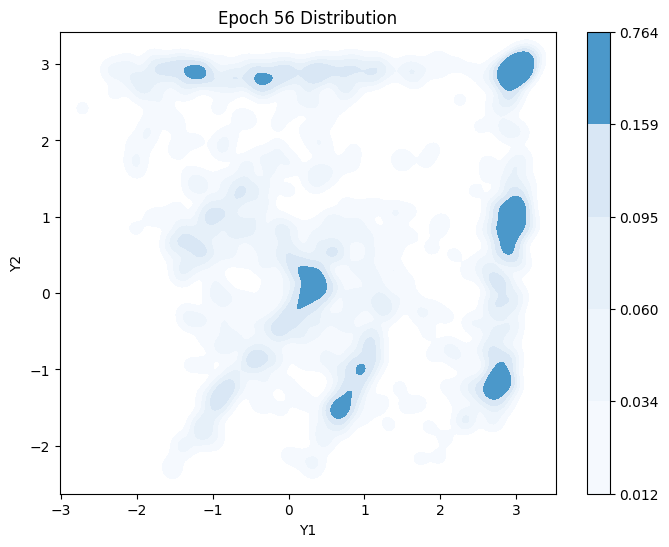

Epoch 56 - D Loss: 0.0804, G Loss: 2.7810
Mean L1 Loss per dimension: tensor([1.4572, 1.4368])
Mean L2 Loss per dimension: tensor([2.8733, 2.8131])
Epoch 57, Iter 2250, D Loss: 0.0722, G Loss: 2.7855, L1: 1.4470, L2: 2.8432
Epoch 57 - D Loss: 0.0729, G Loss: 2.7864
Mean L1 Loss per dimension: tensor([1.4320, 1.4261])
Mean L2 Loss per dimension: tensor([2.7942, 2.7756])
Epoch 58, Iter 2300, D Loss: 0.0830, G Loss: 2.7763, L1: 1.4291, L2: 2.7849
New best multivariate model with L2: 2.7849
Epoch 58 - D Loss: 0.0824, G Loss: 2.7748
Epoch 59 - D Loss: 0.0716, G Loss: 2.7523
Mean L1 Loss per dimension: tensor([1.4554, 1.4434])
Mean L2 Loss per dimension: tensor([2.8751, 2.8317])
Epoch 60, Iter 2350, D Loss: 0.0636, G Loss: 2.7161, L1: 1.4494, L2: 2.8534
Epoch 60 - D Loss: 0.0685, G Loss: 2.7467
Mean L1 Loss per dimension: tensor([1.4690, 1.5062])
Mean L2 Loss per dimension: tensor([2.9134, 3.0210])
Epoch 61, Iter 2400, D Loss: 0.0629, G Loss: 2.7322, L1: 1.4876, L2: 2.9672


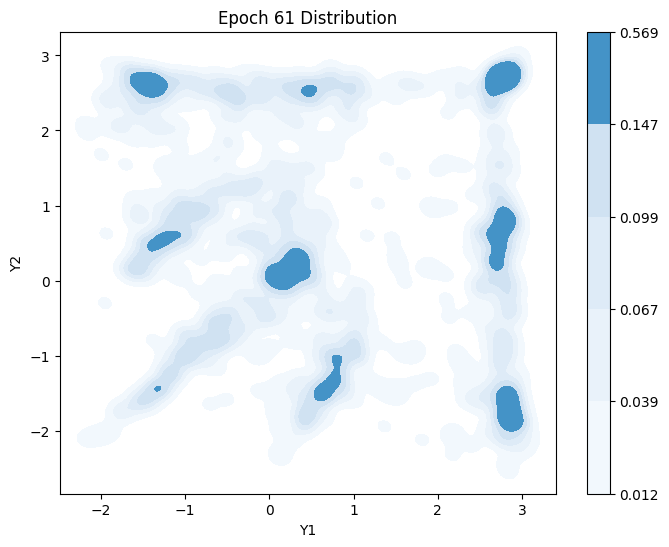

Epoch 61 - D Loss: 0.0786, G Loss: 2.7627
Mean L1 Loss per dimension: tensor([1.4482, 1.4708])
Mean L2 Loss per dimension: tensor([2.8464, 2.8992])
Epoch 62, Iter 2450, D Loss: 0.0746, G Loss: 2.7660, L1: 1.4595, L2: 2.8728
Epoch 62 - D Loss: 0.0774, G Loss: 2.7604
Epoch 63 - D Loss: 0.0703, G Loss: 2.7417
Mean L1 Loss per dimension: tensor([1.4867, 1.4551])
Mean L2 Loss per dimension: tensor([2.9506, 2.8581])
Epoch 64, Iter 2500, D Loss: 0.0446, G Loss: 2.7620, L1: 1.4709, L2: 2.9043
Epoch 64 - D Loss: 0.0684, G Loss: 2.7472
Mean L1 Loss per dimension: tensor([1.4439, 1.4432])
Mean L2 Loss per dimension: tensor([2.8408, 2.8104])
Epoch 65, Iter 2550, D Loss: 0.0761, G Loss: 2.7408, L1: 1.4435, L2: 2.8256
Epoch 65 - D Loss: 0.0707, G Loss: 2.7352
Mean L1 Loss per dimension: tensor([1.4407, 1.4444])
Mean L2 Loss per dimension: tensor([2.8123, 2.8264])
Epoch 66, Iter 2600, D Loss: 0.0580, G Loss: 2.7191, L1: 1.4426, L2: 2.8193


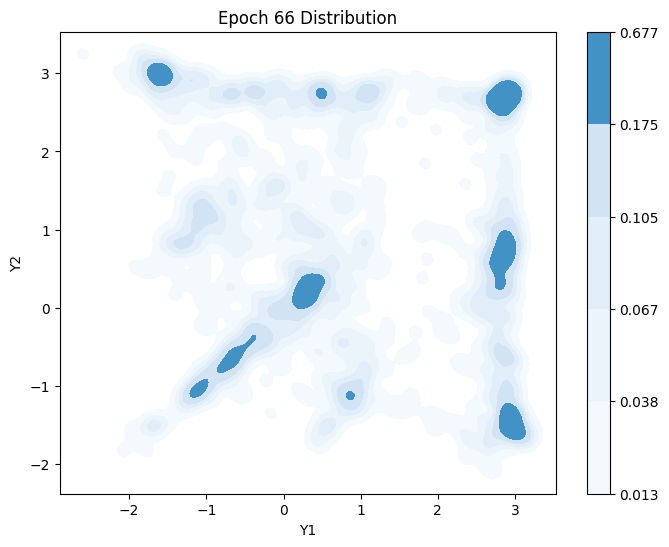

Epoch 66 - D Loss: 0.0649, G Loss: 2.7371
Mean L1 Loss per dimension: tensor([1.4362, 1.4405])
Mean L2 Loss per dimension: tensor([2.8022, 2.8040])
Epoch 67, Iter 2650, D Loss: 0.0653, G Loss: 2.7485, L1: 1.4383, L2: 2.8031
Epoch 67 - D Loss: 0.0644, G Loss: 2.7469
Epoch 68 - D Loss: 0.0575, G Loss: 2.7205
Mean L1 Loss per dimension: tensor([1.4442, 1.4785])
Mean L2 Loss per dimension: tensor([2.8422, 2.9388])
Epoch 69, Iter 2700, D Loss: 0.0496, G Loss: 2.7220, L1: 1.4613, L2: 2.8905
Epoch 69 - D Loss: 0.0603, G Loss: 2.7299
Mean L1 Loss per dimension: tensor([1.4395, 1.4329])
Mean L2 Loss per dimension: tensor([2.8129, 2.8037])
Epoch 70, Iter 2750, D Loss: 0.0561, G Loss: 2.7370, L1: 1.4362, L2: 2.8083
Epoch 70 - D Loss: 0.0534, G Loss: 2.7463
Mean L1 Loss per dimension: tensor([1.4494, 1.4604])
Mean L2 Loss per dimension: tensor([2.8532, 2.8834])
Epoch 71, Iter 2800, D Loss: 0.0601, G Loss: 2.7468, L1: 1.4549, L2: 2.8683


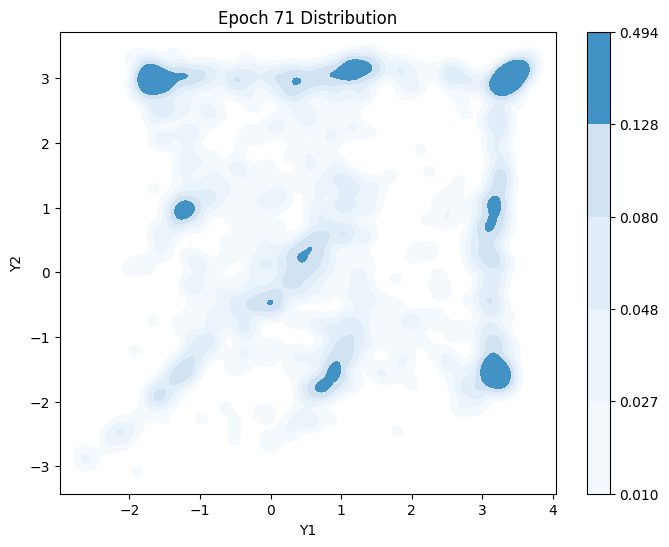

Epoch 71 - D Loss: 0.0581, G Loss: 2.7466
Epoch 72 - D Loss: 0.0594, G Loss: 2.7210
Mean L1 Loss per dimension: tensor([1.4618, 1.4264])
Mean L2 Loss per dimension: tensor([2.8884, 2.7790])
Epoch 73, Iter 2850, D Loss: 0.0360, G Loss: 2.7741, L1: 1.4441, L2: 2.8337
Epoch 73 - D Loss: 0.0552, G Loss: 2.7177
Mean L1 Loss per dimension: tensor([1.4424, 1.4439])
Mean L2 Loss per dimension: tensor([2.8298, 2.8327])
Epoch 74, Iter 2900, D Loss: 0.0416, G Loss: 2.7542, L1: 1.4431, L2: 2.8313
Epoch 74 - D Loss: 0.0485, G Loss: 2.7324
Mean L1 Loss per dimension: tensor([1.4436, 1.4359])
Mean L2 Loss per dimension: tensor([2.8166, 2.7881])
Epoch 75, Iter 2950, D Loss: 0.0532, G Loss: 2.6990, L1: 1.4397, L2: 2.8023
Epoch 75 - D Loss: 0.0502, G Loss: 2.6970
Mean L1 Loss per dimension: tensor([1.4686, 1.4834])
Mean L2 Loss per dimension: tensor([2.9036, 2.9605])
Epoch 76, Iter 3000, D Loss: 0.0557, G Loss: 2.6817, L1: 1.4760, L2: 2.9320


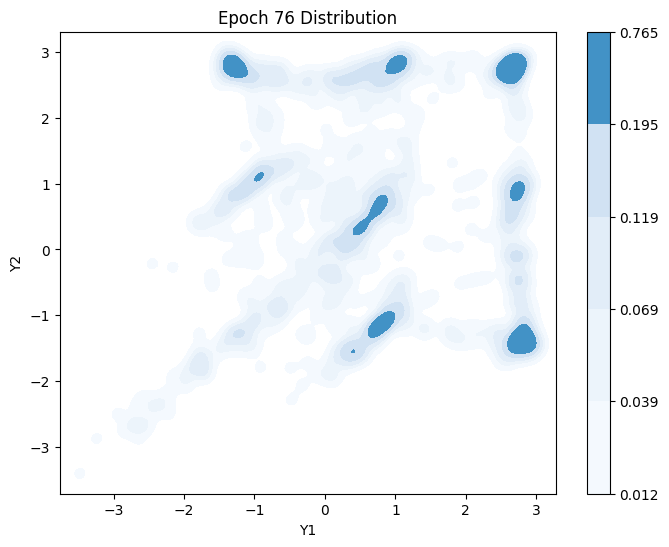

Epoch 76 - D Loss: 0.0563, G Loss: 2.6826
Epoch 77 - D Loss: 0.0468, G Loss: 2.7059
Mean L1 Loss per dimension: tensor([1.4371, 1.4336])
Mean L2 Loss per dimension: tensor([2.8154, 2.7831])
Epoch 78, Iter 3050, D Loss: 0.0480, G Loss: 2.6969, L1: 1.4353, L2: 2.7993
Epoch 78 - D Loss: 0.0502, G Loss: 2.7020
Mean L1 Loss per dimension: tensor([1.4475, 1.4290])
Mean L2 Loss per dimension: tensor([2.8394, 2.7927])
Epoch 79, Iter 3100, D Loss: 0.0520, G Loss: 2.6945, L1: 1.4382, L2: 2.8160
Epoch 79 - D Loss: 0.0470, G Loss: 2.7084
Mean L1 Loss per dimension: tensor([1.4393, 1.4316])
Mean L2 Loss per dimension: tensor([2.8196, 2.7865])
Epoch 80, Iter 3150, D Loss: 0.0425, G Loss: 2.7179, L1: 1.4354, L2: 2.8030
Epoch 80 - D Loss: 0.0416, G Loss: 2.7236
Epoch 81 - D Loss: 0.0431, G Loss: 2.7049
Mean L1 Loss per dimension: tensor([1.4428, 1.4523])
Mean L2 Loss per dimension: tensor([2.8303, 2.8538])
Epoch 82, Iter 3200, D Loss: 0.0339, G Loss: 2.7440, L1: 1.4475, L2: 2.8420


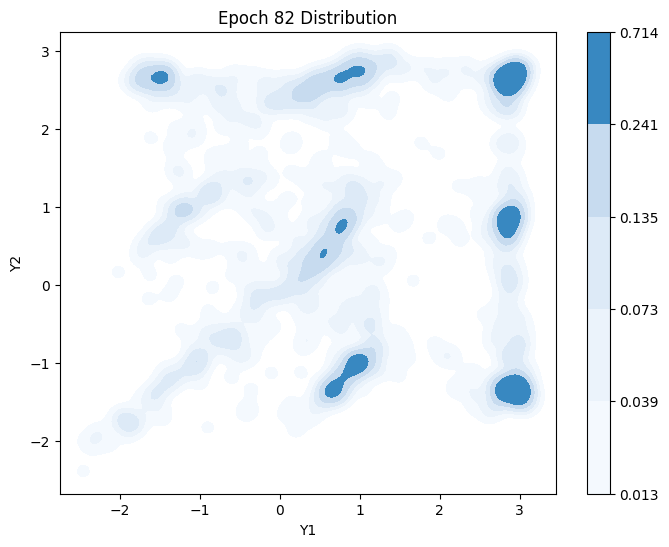

Epoch 82 - D Loss: 0.0584, G Loss: 2.7201
Mean L1 Loss per dimension: tensor([1.4442, 1.4302])
Mean L2 Loss per dimension: tensor([2.8264, 2.7916])
Epoch 83, Iter 3250, D Loss: 0.0400, G Loss: 2.7498, L1: 1.4372, L2: 2.8090
Epoch 83 - D Loss: 0.0435, G Loss: 2.7619
Mean L1 Loss per dimension: tensor([1.4448, 1.4631])
Mean L2 Loss per dimension: tensor([2.8138, 2.8847])
Epoch 84, Iter 3300, D Loss: 0.0454, G Loss: 2.7311, L1: 1.4539, L2: 2.8492
Epoch 84 - D Loss: 0.0446, G Loss: 2.7518
Mean L1 Loss per dimension: tensor([1.4351, 1.4293])
Mean L2 Loss per dimension: tensor([2.8036, 2.7739])
Epoch 85, Iter 3350, D Loss: 0.0440, G Loss: 2.7508, L1: 1.4322, L2: 2.7887
Epoch 85 - D Loss: 0.0418, G Loss: 2.7494
Epoch 86 - D Loss: 0.0479, G Loss: 2.7426
Mean L1 Loss per dimension: tensor([1.4391, 1.4278])
Mean L2 Loss per dimension: tensor([2.8233, 2.7798])
Epoch 87, Iter 3400, D Loss: 0.0498, G Loss: 2.7479, L1: 1.4335, L2: 2.8016


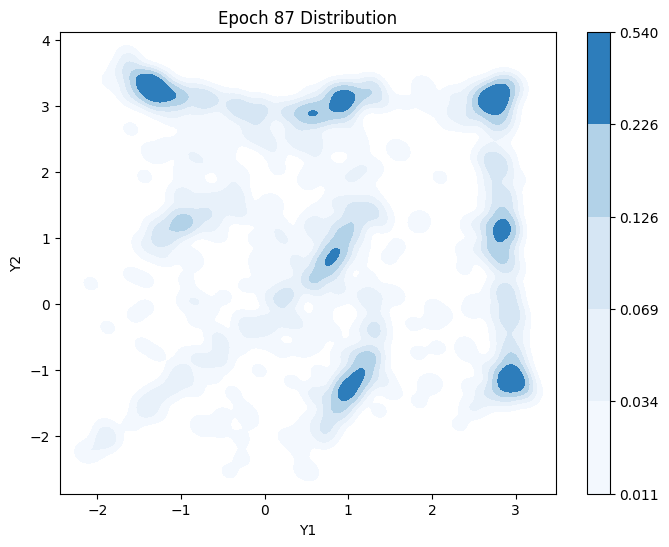

Epoch 87 - D Loss: 0.0454, G Loss: 2.7497
Mean L1 Loss per dimension: tensor([1.4449, 1.4425])
Mean L2 Loss per dimension: tensor([2.8392, 2.8346])
Epoch 88, Iter 3450, D Loss: 0.0380, G Loss: 2.7616, L1: 1.4437, L2: 2.8369
Epoch 88 - D Loss: 0.0403, G Loss: 2.7615
Mean L1 Loss per dimension: tensor([1.4396, 1.4195])
Mean L2 Loss per dimension: tensor([2.8120, 2.7411])
Epoch 89, Iter 3500, D Loss: 0.0494, G Loss: 2.7425, L1: 1.4296, L2: 2.7766
New best multivariate model with L2: 2.7766
Epoch 89 - D Loss: 0.0463, G Loss: 2.7423
Epoch 90 - D Loss: 0.0402, G Loss: 2.7671
Mean L1 Loss per dimension: tensor([1.4474, 1.4379])
Mean L2 Loss per dimension: tensor([2.8381, 2.8011])
Epoch 91, Iter 3550, D Loss: 0.0437, G Loss: 2.7291, L1: 1.4427, L2: 2.8196
Epoch 91 - D Loss: 0.0422, G Loss: 2.7666
Mean L1 Loss per dimension: tensor([1.4677, 1.4337])
Mean L2 Loss per dimension: tensor([2.9032, 2.7845])
Epoch 92, Iter 3600, D Loss: 0.0458, G Loss: 2.7418, L1: 1.4507, L2: 2.8438


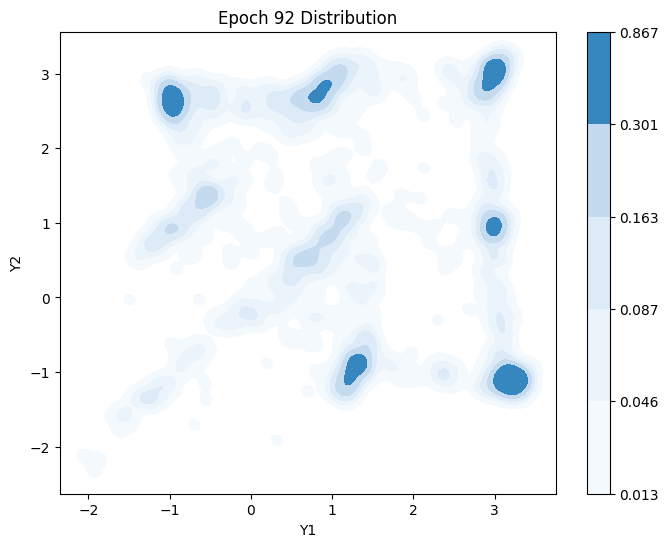

Epoch 92 - D Loss: 0.0485, G Loss: 2.7649
Mean L1 Loss per dimension: tensor([1.4360, 1.4357])
Mean L2 Loss per dimension: tensor([2.8067, 2.7885])
Epoch 93, Iter 3650, D Loss: 0.0311, G Loss: 2.7441, L1: 1.4358, L2: 2.7976
Epoch 93 - D Loss: 0.0342, G Loss: 2.7487
Mean L1 Loss per dimension: tensor([1.4359, 1.4332])
Mean L2 Loss per dimension: tensor([2.8098, 2.8068])
Epoch 94, Iter 3700, D Loss: 0.0391, G Loss: 2.7649, L1: 1.4345, L2: 2.8083
Epoch 94 - D Loss: 0.0394, G Loss: 2.7640
Epoch 95 - D Loss: 0.0419, G Loss: 2.7577
Mean L1 Loss per dimension: tensor([1.4405, 1.4228])
Mean L2 Loss per dimension: tensor([2.8331, 2.7555])
Epoch 96, Iter 3750, D Loss: 0.0340, G Loss: 2.7836, L1: 1.4317, L2: 2.7943
Epoch 96 - D Loss: 0.0403, G Loss: 2.7676
Mean L1 Loss per dimension: tensor([1.4364, 1.4309])
Mean L2 Loss per dimension: tensor([2.8042, 2.7972])
Epoch 97, Iter 3800, D Loss: 0.0310, G Loss: 2.7339, L1: 1.4337, L2: 2.8007


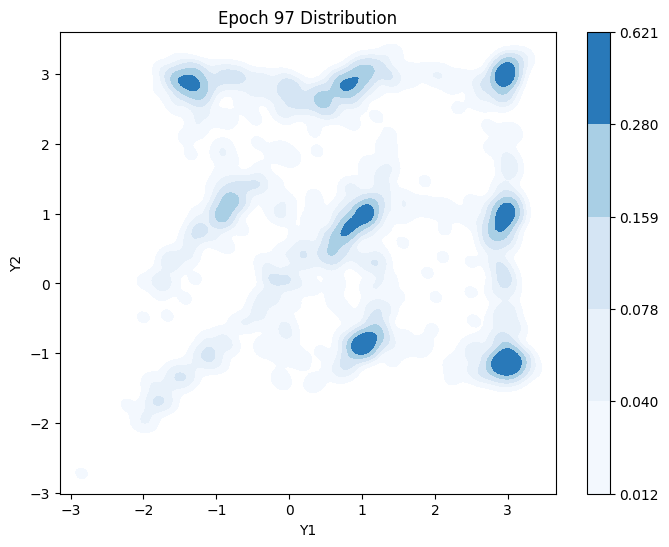

Epoch 97 - D Loss: 0.0331, G Loss: 2.7498
Mean L1 Loss per dimension: tensor([1.4591, 1.4201])
Mean L2 Loss per dimension: tensor([2.8673, 2.7540])
Epoch 98, Iter 3850, D Loss: 0.0327, G Loss: 2.7413, L1: 1.4396, L2: 2.8107
Epoch 98 - D Loss: 0.0349, G Loss: 2.7437
Mean L1 Loss per dimension: tensor([1.4290, 1.4294])
Mean L2 Loss per dimension: tensor([2.7807, 2.7838])
Epoch 99, Iter 3900, D Loss: 0.0377, G Loss: 2.7114, L1: 1.4292, L2: 2.7822
Epoch 99 - D Loss: 0.0377, G Loss: 2.7114
Epoch 100 - D Loss: 0.0313, G Loss: 2.7332
Mean L1 Loss per dimension: tensor([1.4251, 1.4688])
Mean L2 Loss per dimension: tensor([2.7761, 2.8922])
Epoch 101, Iter 3950, D Loss: 0.0258, G Loss: 2.7129, L1: 1.4470, L2: 2.8341
Epoch 101 - D Loss: 0.0336, G Loss: 2.7310
Mean L1 Loss per dimension: tensor([1.4448, 1.4451])
Mean L2 Loss per dimension: tensor([2.8416, 2.8201])
Epoch 102, Iter 4000, D Loss: 0.0293, G Loss: 2.7202, L1: 1.4450, L2: 2.8309


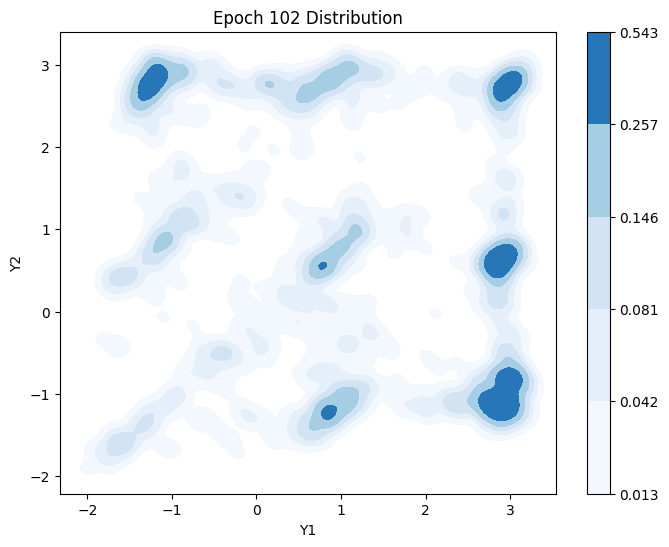

Epoch 102 - D Loss: 0.0273, G Loss: 2.7135
Mean L1 Loss per dimension: tensor([1.4358, 1.4538])
Mean L2 Loss per dimension: tensor([2.8009, 2.8628])
Epoch 103, Iter 4050, D Loss: 0.0342, G Loss: 2.7315, L1: 1.4448, L2: 2.8319
Epoch 103 - D Loss: 0.0333, G Loss: 2.7245
Epoch 104 - D Loss: 0.0267, G Loss: 2.7004
Mean L1 Loss per dimension: tensor([1.4247, 1.4176])
Mean L2 Loss per dimension: tensor([2.7707, 2.7396])
Epoch 105, Iter 4100, D Loss: 0.0349, G Loss: 2.6545, L1: 1.4211, L2: 2.7552
New best multivariate model with L2: 2.7552
Epoch 105 - D Loss: 0.0303, G Loss: 2.6978
Mean L1 Loss per dimension: tensor([1.4442, 1.4317])
Mean L2 Loss per dimension: tensor([2.8180, 2.7923])
Epoch 106, Iter 4150, D Loss: 0.0258, G Loss: 2.6826, L1: 1.4379, L2: 2.8052
Epoch 106 - D Loss: 0.0324, G Loss: 2.6852
Mean L1 Loss per dimension: tensor([1.4331, 1.4564])
Mean L2 Loss per dimension: tensor([2.7936, 2.8621])
Epoch 107, Iter 4200, D Loss: 0.0248, G Loss: 2.6827, L1: 1.4447, L2: 2.8278


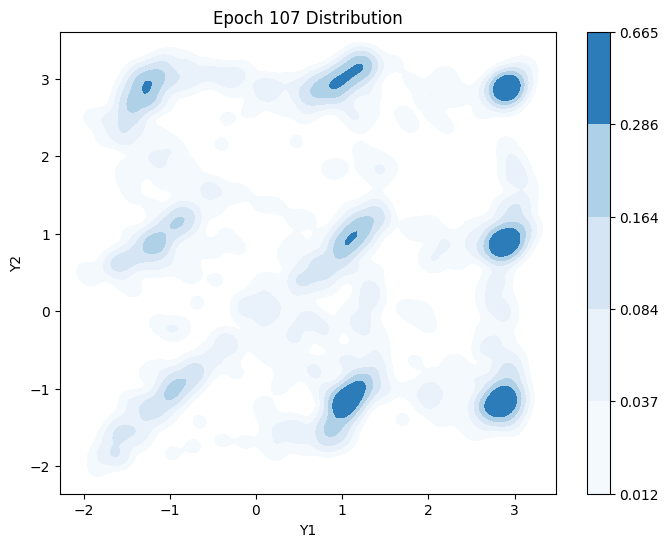

Epoch 107 - D Loss: 0.0258, G Loss: 2.6678
Mean L1 Loss per dimension: tensor([1.4337, 1.4337])
Mean L2 Loss per dimension: tensor([2.8150, 2.8054])
Epoch 108, Iter 4250, D Loss: 0.0287, G Loss: 2.6721, L1: 1.4337, L2: 2.8102
Epoch 108 - D Loss: 0.0288, G Loss: 2.6735
Epoch 109 - D Loss: 0.0233, G Loss: 2.6664
Mean L1 Loss per dimension: tensor([1.4391, 1.4298])
Mean L2 Loss per dimension: tensor([2.8157, 2.7796])
Epoch 110, Iter 4300, D Loss: 0.0362, G Loss: 2.6575, L1: 1.4345, L2: 2.7977
Epoch 110 - D Loss: 0.0276, G Loss: 2.6589
Mean L1 Loss per dimension: tensor([1.4703, 1.4366])
Mean L2 Loss per dimension: tensor([2.9065, 2.8015])
Epoch 111, Iter 4350, D Loss: 0.0237, G Loss: 2.6721, L1: 1.4535, L2: 2.8540
Epoch 111 - D Loss: 0.0233, G Loss: 2.6711
Mean L1 Loss per dimension: tensor([1.4336, 1.4257])
Mean L2 Loss per dimension: tensor([2.8019, 2.7704])
Epoch 112, Iter 4400, D Loss: 0.0266, G Loss: 2.6470, L1: 1.4296, L2: 2.7861


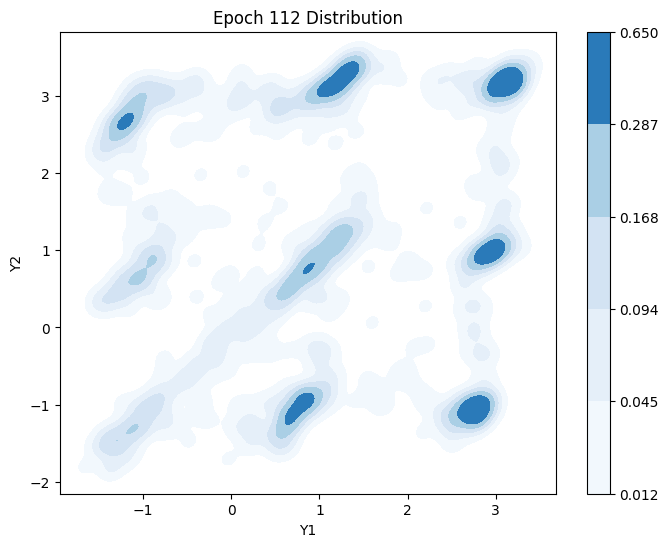

Epoch 112 - D Loss: 0.0271, G Loss: 2.6530
Epoch 113 - D Loss: 0.0257, G Loss: 2.6541
Mean L1 Loss per dimension: tensor([1.4487, 1.4443])
Mean L2 Loss per dimension: tensor([2.8503, 2.8016])
Epoch 114, Iter 4450, D Loss: 0.0254, G Loss: 2.7360, L1: 1.4465, L2: 2.8260
Epoch 114 - D Loss: 0.0199, G Loss: 2.6685
Mean L1 Loss per dimension: tensor([1.4330, 1.4522])
Mean L2 Loss per dimension: tensor([2.7806, 2.8530])
Epoch 115, Iter 4500, D Loss: 0.0238, G Loss: 2.6535, L1: 1.4426, L2: 2.8168
Epoch 115 - D Loss: 0.0281, G Loss: 2.6350
Mean L1 Loss per dimension: tensor([1.4504, 1.4439])
Mean L2 Loss per dimension: tensor([2.8574, 2.8197])
Epoch 116, Iter 4550, D Loss: 0.0227, G Loss: 2.6494, L1: 1.4472, L2: 2.8385
Epoch 116 - D Loss: 0.0199, G Loss: 2.6454
Mean L1 Loss per dimension: tensor([1.4336, 1.4513])
Mean L2 Loss per dimension: tensor([2.8022, 2.8579])
Epoch 117, Iter 4600, D Loss: 0.0264, G Loss: 2.6272, L1: 1.4424, L2: 2.8301


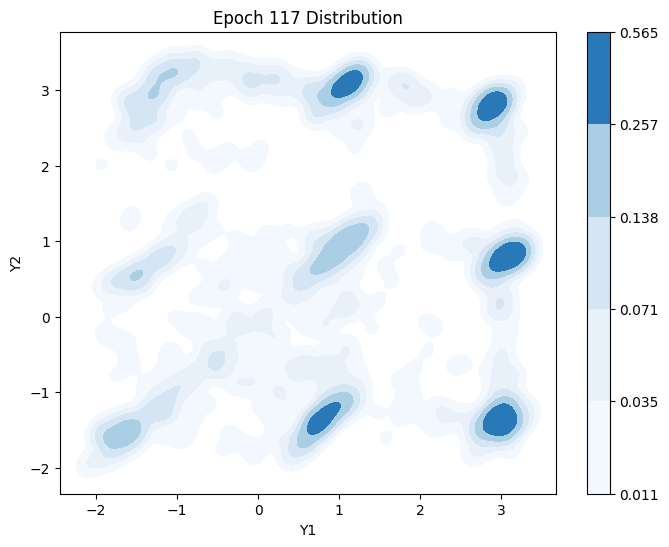

Epoch 117 - D Loss: 0.0259, G Loss: 2.6260
Epoch 118 - D Loss: 0.0246, G Loss: 2.6013
Mean L1 Loss per dimension: tensor([1.4475, 1.4488])
Mean L2 Loss per dimension: tensor([2.8412, 2.8494])
Epoch 119, Iter 4650, D Loss: 0.0208, G Loss: 2.5654, L1: 1.4482, L2: 2.8453
Epoch 119 - D Loss: 0.0183, G Loss: 2.6215
Mean L1 Loss per dimension: tensor([1.4448, 1.4331])
Mean L2 Loss per dimension: tensor([2.8453, 2.7946])
Epoch 120, Iter 4700, D Loss: 0.0258, G Loss: 2.6069, L1: 1.4390, L2: 2.8199
Epoch 120 - D Loss: 0.0242, G Loss: 2.6112
Mean L1 Loss per dimension: tensor([1.4253, 1.4359])
Mean L2 Loss per dimension: tensor([2.7619, 2.7988])
Epoch 121, Iter 4750, D Loss: 0.0228, G Loss: 2.6257, L1: 1.4306, L2: 2.7804
Epoch 121 - D Loss: 0.0229, G Loss: 2.6119
Epoch 122 - D Loss: 0.0233, G Loss: 2.5990
Mean L1 Loss per dimension: tensor([1.4278, 1.4415])
Mean L2 Loss per dimension: tensor([2.7776, 2.8145])
Epoch 123, Iter 4800, D Loss: 0.0204, G Loss: 2.5365, L1: 1.4346, L2: 2.7961


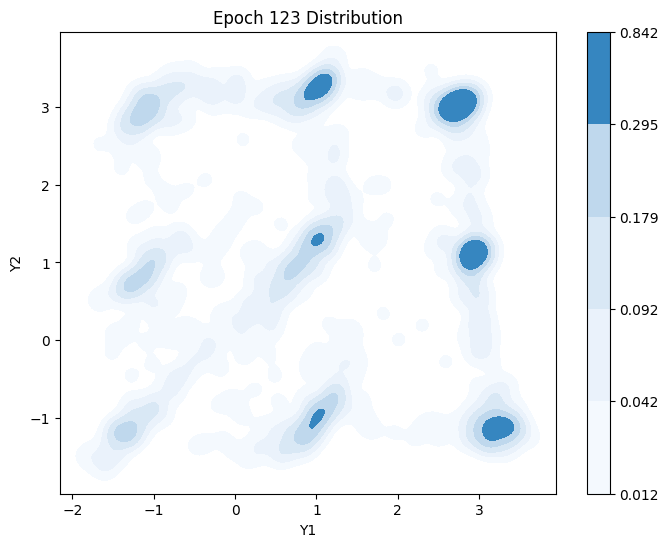

Epoch 123 - D Loss: 0.0249, G Loss: 2.5670
Mean L1 Loss per dimension: tensor([1.4403, 1.4281])
Mean L2 Loss per dimension: tensor([2.8271, 2.7727])
Epoch 124, Iter 4850, D Loss: 0.0226, G Loss: 2.5709, L1: 1.4342, L2: 2.7999
Epoch 124 - D Loss: 0.0211, G Loss: 2.5676
Mean L1 Loss per dimension: tensor([1.4450, 1.4265])
Mean L2 Loss per dimension: tensor([2.8176, 2.7764])
Epoch 125, Iter 4900, D Loss: 0.0250, G Loss: 2.5709, L1: 1.4357, L2: 2.7970
Epoch 125 - D Loss: 0.0246, G Loss: 2.5710
Mean L1 Loss per dimension: tensor([1.4541, 1.4369])
Mean L2 Loss per dimension: tensor([2.8608, 2.7922])
Epoch 126, Iter 4950, D Loss: 0.0215, G Loss: 2.5686, L1: 1.4455, L2: 2.8265
Epoch 126 - D Loss: 0.0228, G Loss: 2.5773
Epoch 127 - D Loss: 0.0208, G Loss: 2.5828
Mean L1 Loss per dimension: tensor([1.4446, 1.4576])
Mean L2 Loss per dimension: tensor([2.8402, 2.8750])
Epoch 128, Iter 5000, D Loss: 0.0147, G Loss: 2.6145, L1: 1.4511, L2: 2.8576


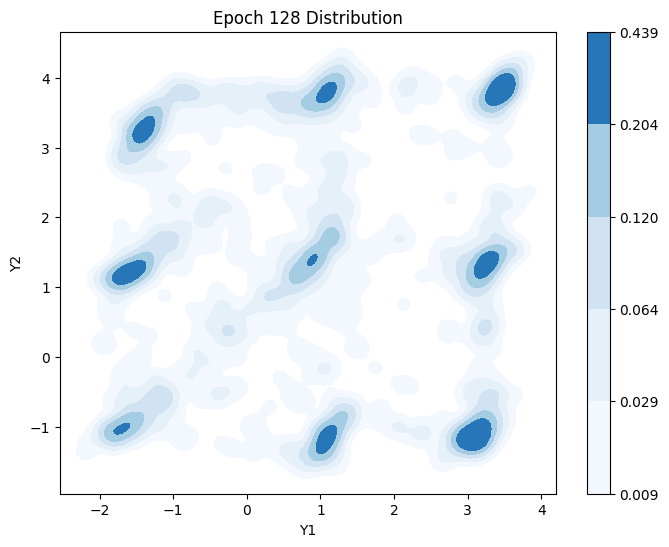

Epoch 128 - D Loss: 0.0244, G Loss: 2.5705
Mean L1 Loss per dimension: tensor([1.4670, 1.4364])
Mean L2 Loss per dimension: tensor([2.8990, 2.8075])
Epoch 129, Iter 5050, D Loss: 0.0185, G Loss: 2.5318, L1: 1.4517, L2: 2.8532
Epoch 129 - D Loss: 0.0238, G Loss: 2.5500
Mean L1 Loss per dimension: tensor([1.4380, 1.4304])
Mean L2 Loss per dimension: tensor([2.8073, 2.7812])
Epoch 130, Iter 5100, D Loss: 0.0199, G Loss: 2.5709, L1: 1.4342, L2: 2.7943
Epoch 130 - D Loss: 0.0195, G Loss: 2.5700
Epoch 131 - D Loss: 0.0189, G Loss: 2.5934
Mean L1 Loss per dimension: tensor([1.4253, 1.4310])
Mean L2 Loss per dimension: tensor([2.7865, 2.7713])
Epoch 132, Iter 5150, D Loss: 0.0082, G Loss: 2.6182, L1: 1.4281, L2: 2.7789
Epoch 132 - D Loss: 0.0202, G Loss: 2.5865
Mean L1 Loss per dimension: tensor([1.4707, 1.4408])
Mean L2 Loss per dimension: tensor([2.9116, 2.8012])
Epoch 133, Iter 5200, D Loss: 0.0200, G Loss: 2.5603, L1: 1.4557, L2: 2.8564


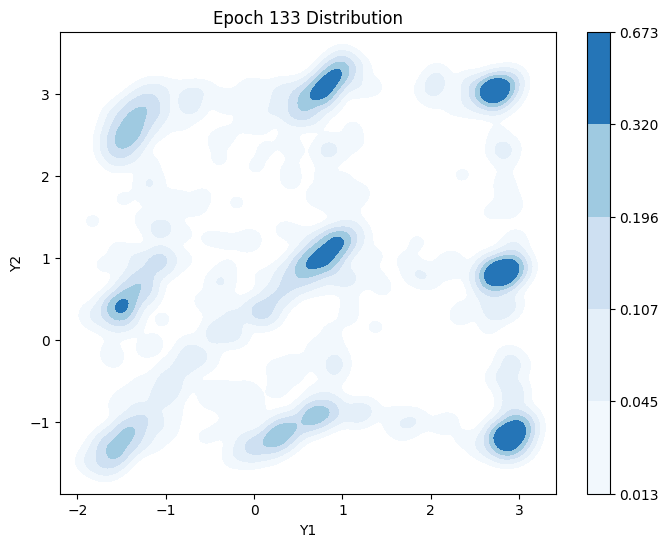

Epoch 133 - D Loss: 0.0225, G Loss: 2.6025
Mean L1 Loss per dimension: tensor([1.4366, 1.4288])
Mean L2 Loss per dimension: tensor([2.8291, 2.7790])
Epoch 134, Iter 5250, D Loss: 0.0206, G Loss: 2.6158, L1: 1.4327, L2: 2.8040
Epoch 134 - D Loss: 0.0205, G Loss: 2.5956
Mean L1 Loss per dimension: tensor([1.4386, 1.4451])
Mean L2 Loss per dimension: tensor([2.8347, 2.8111])
Epoch 135, Iter 5300, D Loss: 0.0181, G Loss: 2.5912, L1: 1.4419, L2: 2.8229
Epoch 135 - D Loss: 0.0187, G Loss: 2.5904
Epoch 136 - D Loss: 0.0195, G Loss: 2.5651
Mean L1 Loss per dimension: tensor([1.4413, 1.4311])
Mean L2 Loss per dimension: tensor([2.8263, 2.7902])
Epoch 137, Iter 5350, D Loss: 0.0182, G Loss: 2.5893, L1: 1.4362, L2: 2.8083
Epoch 137 - D Loss: 0.0202, G Loss: 2.5576
Mean L1 Loss per dimension: tensor([1.4392, 1.4410])
Mean L2 Loss per dimension: tensor([2.8273, 2.7875])
Epoch 138, Iter 5400, D Loss: 0.0172, G Loss: 2.5746, L1: 1.4401, L2: 2.8074


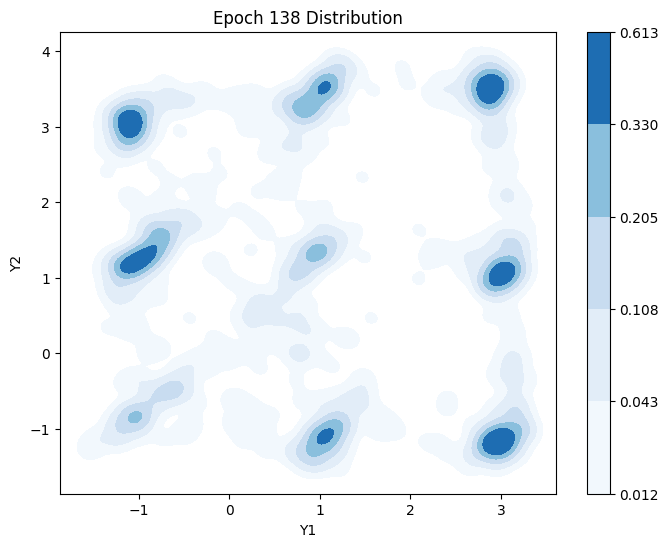

Epoch 138 - D Loss: 0.0182, G Loss: 2.5739
Mean L1 Loss per dimension: tensor([1.4482, 1.4503])
Mean L2 Loss per dimension: tensor([2.8497, 2.8380])
Epoch 139, Iter 5450, D Loss: 0.0195, G Loss: 2.5837, L1: 1.4492, L2: 2.8438
Epoch 139 - D Loss: 0.0199, G Loss: 2.5854
Epoch 140 - D Loss: 0.0187, G Loss: 2.5802
Mean L1 Loss per dimension: tensor([1.4270, 1.4269])
Mean L2 Loss per dimension: tensor([2.7839, 2.7714])
Epoch 141, Iter 5500, D Loss: 0.0206, G Loss: 2.5648, L1: 1.4269, L2: 2.7776
Epoch 141 - D Loss: 0.0180, G Loss: 2.5628
Mean L1 Loss per dimension: tensor([1.4366, 1.4445])
Mean L2 Loss per dimension: tensor([2.8143, 2.8085])
Epoch 142, Iter 5550, D Loss: 0.0171, G Loss: 2.5588, L1: 1.4406, L2: 2.8114
Epoch 142 - D Loss: 0.0182, G Loss: 2.5750
Mean L1 Loss per dimension: tensor([1.4273, 1.4356])
Mean L2 Loss per dimension: tensor([2.7722, 2.8025])
Epoch 143, Iter 5600, D Loss: 0.0233, G Loss: 2.5787, L1: 1.4315, L2: 2.7873


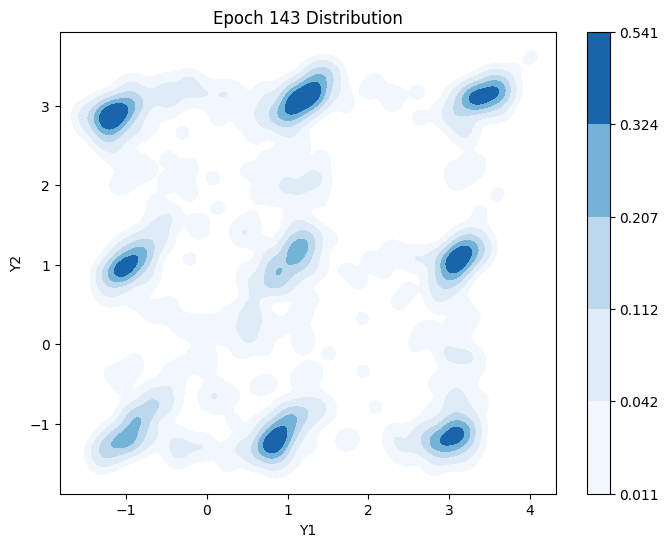

Epoch 143 - D Loss: 0.0201, G Loss: 2.5746
Mean L1 Loss per dimension: tensor([1.4446, 1.4269])
Mean L2 Loss per dimension: tensor([2.8425, 2.7671])
Epoch 144, Iter 5650, D Loss: 0.0179, G Loss: 2.5706, L1: 1.4357, L2: 2.8048
Epoch 144 - D Loss: 0.0176, G Loss: 2.5701
Epoch 145 - D Loss: 0.0176, G Loss: 2.5562
Mean L1 Loss per dimension: tensor([1.4320, 1.4244])
Mean L2 Loss per dimension: tensor([2.7884, 2.7702])
Epoch 146, Iter 5700, D Loss: 0.0184, G Loss: 2.5658, L1: 1.4282, L2: 2.7793
Epoch 146 - D Loss: 0.0172, G Loss: 2.5705
Mean L1 Loss per dimension: tensor([1.4473, 1.4390])
Mean L2 Loss per dimension: tensor([2.8404, 2.8109])
Epoch 147, Iter 5750, D Loss: 0.0174, G Loss: 2.5765, L1: 1.4432, L2: 2.8257
Epoch 147 - D Loss: 0.0176, G Loss: 2.5773
Mean L1 Loss per dimension: tensor([1.4443, 1.4343])
Mean L2 Loss per dimension: tensor([2.8436, 2.8056])
Epoch 148, Iter 5800, D Loss: 0.0200, G Loss: 2.5656, L1: 1.4393, L2: 2.8246


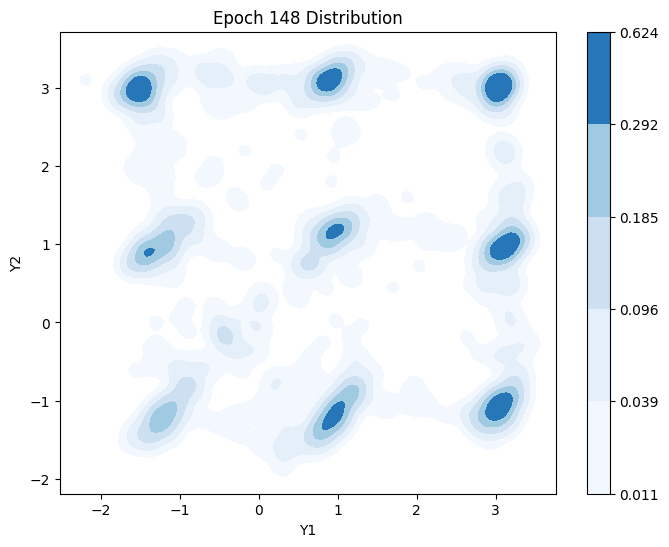

Epoch 148 - D Loss: 0.0198, G Loss: 2.5647
Mean L1 Loss per dimension: tensor([1.4375, 1.4480])
Mean L2 Loss per dimension: tensor([2.8290, 2.8196])
Epoch 149, Iter 5850, D Loss: 0.0155, G Loss: 2.5685, L1: 1.4428, L2: 2.8243
Epoch 149 - D Loss: 0.0155, G Loss: 2.5685
Epoch 150 - D Loss: 0.0191, G Loss: 2.5488
Mean L1 Loss per dimension: tensor([1.4458, 1.4376])
Mean L2 Loss per dimension: tensor([2.8484, 2.8374])
Epoch 151, Iter 5900, D Loss: 0.0144, G Loss: 2.5374, L1: 1.4417, L2: 2.8429
Epoch 151 - D Loss: 0.0153, G Loss: 2.5353
Mean L1 Loss per dimension: tensor([1.4309, 1.4241])
Mean L2 Loss per dimension: tensor([2.7906, 2.7617])
Epoch 152, Iter 5950, D Loss: 0.0159, G Loss: 2.5495, L1: 1.4275, L2: 2.7761
Epoch 152 - D Loss: 0.0157, G Loss: 2.5368
Mean L1 Loss per dimension: tensor([1.4335, 1.4263])
Mean L2 Loss per dimension: tensor([2.7962, 2.7698])
Epoch 153, Iter 6000, D Loss: 0.0180, G Loss: 2.5550, L1: 1.4299, L2: 2.7830


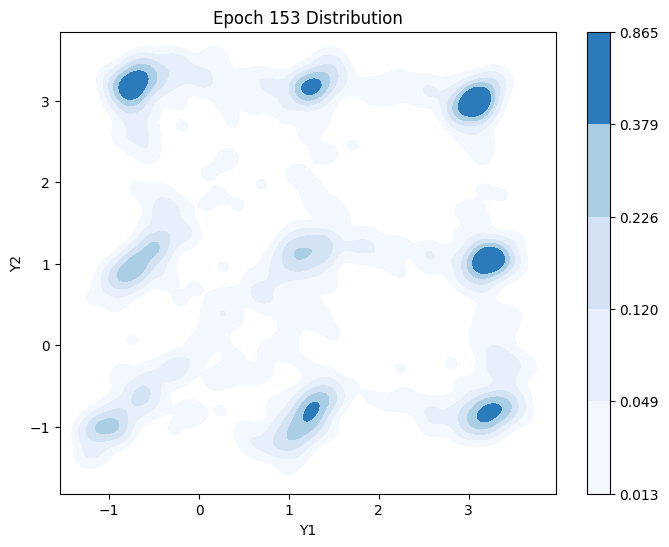

Epoch 153 - D Loss: 0.0177, G Loss: 2.5573
Epoch 154 - D Loss: 0.0159, G Loss: 2.5670
Mean L1 Loss per dimension: tensor([1.4367, 1.4659])
Mean L2 Loss per dimension: tensor([2.8279, 2.8938])
Epoch 155, Iter 6050, D Loss: 0.0163, G Loss: 2.5363, L1: 1.4513, L2: 2.8608
Epoch 155 - D Loss: 0.0179, G Loss: 2.5404
Mean L1 Loss per dimension: tensor([1.4414, 1.4240])
Mean L2 Loss per dimension: tensor([2.8184, 2.7729])
Epoch 156, Iter 6100, D Loss: 0.0149, G Loss: 2.5336, L1: 1.4327, L2: 2.7957
Epoch 156 - D Loss: 0.0169, G Loss: 2.5451
Mean L1 Loss per dimension: tensor([1.4434, 1.4563])
Mean L2 Loss per dimension: tensor([2.8323, 2.8493])
Epoch 157, Iter 6150, D Loss: 0.0152, G Loss: 2.5559, L1: 1.4499, L2: 2.8408
Epoch 157 - D Loss: 0.0145, G Loss: 2.5512
Mean L1 Loss per dimension: tensor([1.4378, 1.4273])
Mean L2 Loss per dimension: tensor([2.8172, 2.7725])
Epoch 158, Iter 6200, D Loss: 0.0176, G Loss: 2.5137, L1: 1.4326, L2: 2.7949


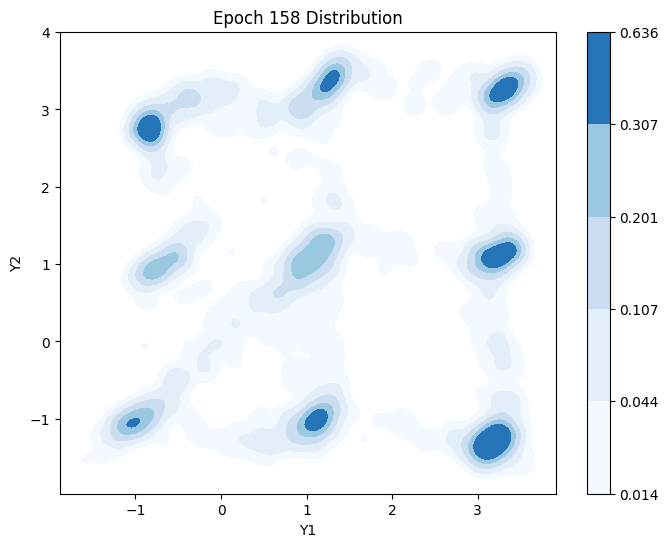

Epoch 158 - D Loss: 0.0182, G Loss: 2.5158
Epoch 159 - D Loss: 0.0165, G Loss: 2.5171
Mean L1 Loss per dimension: tensor([1.4419, 1.4305])
Mean L2 Loss per dimension: tensor([2.8355, 2.7806])
Epoch 160, Iter 6250, D Loss: 0.0172, G Loss: 2.5411, L1: 1.4362, L2: 2.8080
Epoch 160 - D Loss: 0.0170, G Loss: 2.5426
Mean L1 Loss per dimension: tensor([1.4345, 1.4399])
Mean L2 Loss per dimension: tensor([2.7964, 2.8155])
Epoch 161, Iter 6300, D Loss: 0.0189, G Loss: 2.5339, L1: 1.4372, L2: 2.8059
Epoch 161 - D Loss: 0.0162, G Loss: 2.5288
Mean L1 Loss per dimension: tensor([1.4421, 1.4309])
Mean L2 Loss per dimension: tensor([2.8110, 2.7928])
Epoch 162, Iter 6350, D Loss: 0.0183, G Loss: 2.5313, L1: 1.4365, L2: 2.8019
Epoch 162 - D Loss: 0.0183, G Loss: 2.5300
Epoch 163 - D Loss: 0.0143, G Loss: 2.5253
Mean L1 Loss per dimension: tensor([1.4551, 1.4325])
Mean L2 Loss per dimension: tensor([2.8832, 2.7843])
Epoch 164, Iter 6400, D Loss: 0.0210, G Loss: 2.5781, L1: 1.4438, L2: 2.8337


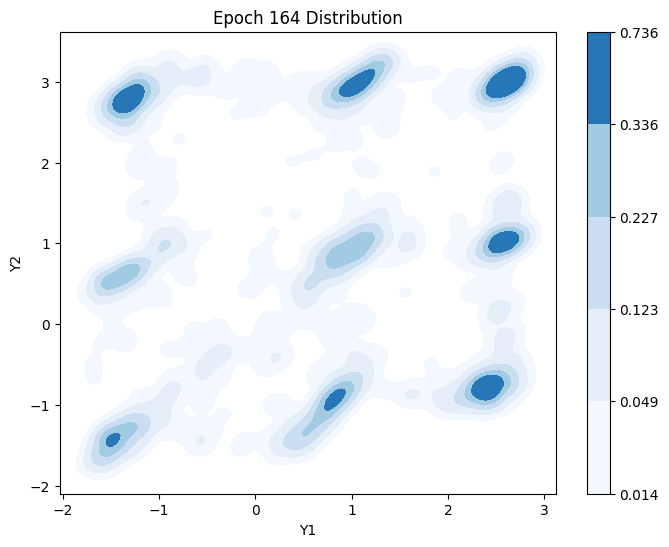

Epoch 164 - D Loss: 0.0182, G Loss: 2.5363
Mean L1 Loss per dimension: tensor([1.4345, 1.4422])
Mean L2 Loss per dimension: tensor([2.8096, 2.8262])
Epoch 165, Iter 6450, D Loss: 0.0188, G Loss: 2.5209, L1: 1.4384, L2: 2.8179
Epoch 165 - D Loss: 0.0174, G Loss: 2.5215
Mean L1 Loss per dimension: tensor([1.4333, 1.4380])
Mean L2 Loss per dimension: tensor([2.8034, 2.8039])
Epoch 166, Iter 6500, D Loss: 0.0175, G Loss: 2.5386, L1: 1.4357, L2: 2.8036
Epoch 166 - D Loss: 0.0166, G Loss: 2.5322
Mean L1 Loss per dimension: tensor([1.4377, 1.4395])
Mean L2 Loss per dimension: tensor([2.8135, 2.8276])
Epoch 167, Iter 6550, D Loss: 0.0147, G Loss: 2.5321, L1: 1.4386, L2: 2.8205
Epoch 167 - D Loss: 0.0146, G Loss: 2.5329
Epoch 168 - D Loss: 0.0172, G Loss: 2.5252
Mean L1 Loss per dimension: tensor([1.4454, 1.4426])
Mean L2 Loss per dimension: tensor([2.8425, 2.8196])
Epoch 169, Iter 6600, D Loss: 0.0150, G Loss: 2.5268, L1: 1.4440, L2: 2.8310


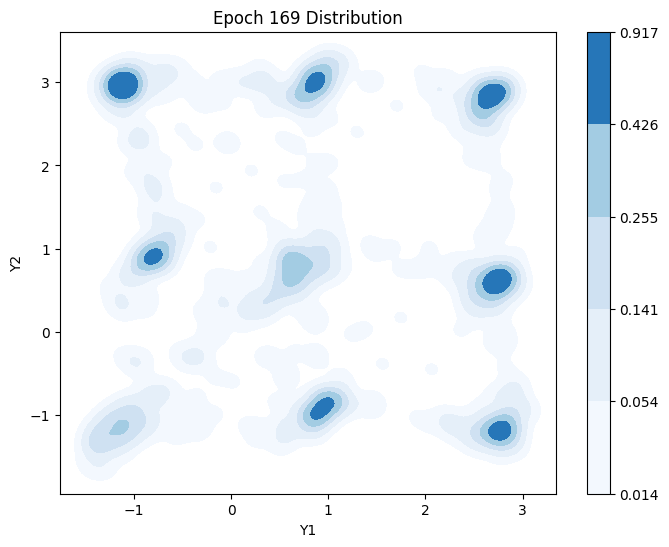

Epoch 169 - D Loss: 0.0181, G Loss: 2.5401
Mean L1 Loss per dimension: tensor([1.4495, 1.4789])
Mean L2 Loss per dimension: tensor([2.8522, 2.9265])
Epoch 170, Iter 6650, D Loss: 0.0145, G Loss: 2.5047, L1: 1.4642, L2: 2.8894
Epoch 170 - D Loss: 0.0147, G Loss: 2.5222
Mean L1 Loss per dimension: tensor([1.4390, 1.4489])
Mean L2 Loss per dimension: tensor([2.8294, 2.8502])
Epoch 171, Iter 6700, D Loss: 0.0145, G Loss: 2.5242, L1: 1.4440, L2: 2.8398
Epoch 171 - D Loss: 0.0155, G Loss: 2.5270
Epoch 172 - D Loss: 0.0153, G Loss: 2.5248
Mean L1 Loss per dimension: tensor([1.4456, 1.4402])
Mean L2 Loss per dimension: tensor([2.8544, 2.8175])
Epoch 173, Iter 6750, D Loss: 0.0265, G Loss: 2.5014, L1: 1.4429, L2: 2.8360
Epoch 173 - D Loss: 0.0186, G Loss: 2.5272
Mean L1 Loss per dimension: tensor([1.4235, 1.4213])
Mean L2 Loss per dimension: tensor([2.7811, 2.7596])
Epoch 174, Iter 6800, D Loss: 0.0154, G Loss: 2.5385, L1: 1.4224, L2: 2.7704


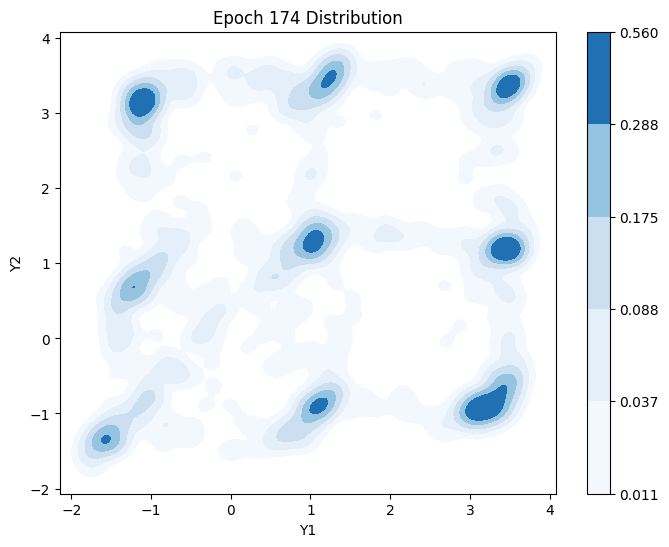

Epoch 174 - D Loss: 0.0171, G Loss: 2.5391
Mean L1 Loss per dimension: tensor([1.4507, 1.4378])
Mean L2 Loss per dimension: tensor([2.8537, 2.8109])
Epoch 175, Iter 6850, D Loss: 0.0122, G Loss: 2.5404, L1: 1.4443, L2: 2.8323
Epoch 175 - D Loss: 0.0113, G Loss: 2.5335
Mean L1 Loss per dimension: tensor([1.4456, 1.4420])
Mean L2 Loss per dimension: tensor([2.8414, 2.8287])
Epoch 176, Iter 6900, D Loss: 0.0175, G Loss: 2.5364, L1: 1.4438, L2: 2.8351
Epoch 176 - D Loss: 0.0176, G Loss: 2.5378
Epoch 177 - D Loss: 0.0144, G Loss: 2.5497
Mean L1 Loss per dimension: tensor([1.4415, 1.4360])
Mean L2 Loss per dimension: tensor([2.8205, 2.7914])
Epoch 178, Iter 6950, D Loss: 0.0197, G Loss: 2.5764, L1: 1.4387, L2: 2.8060
Epoch 178 - D Loss: 0.0149, G Loss: 2.5206
Mean L1 Loss per dimension: tensor([1.4272, 1.4404])
Mean L2 Loss per dimension: tensor([2.7858, 2.8172])
Epoch 179, Iter 7000, D Loss: 0.0168, G Loss: 2.5240, L1: 1.4338, L2: 2.8015


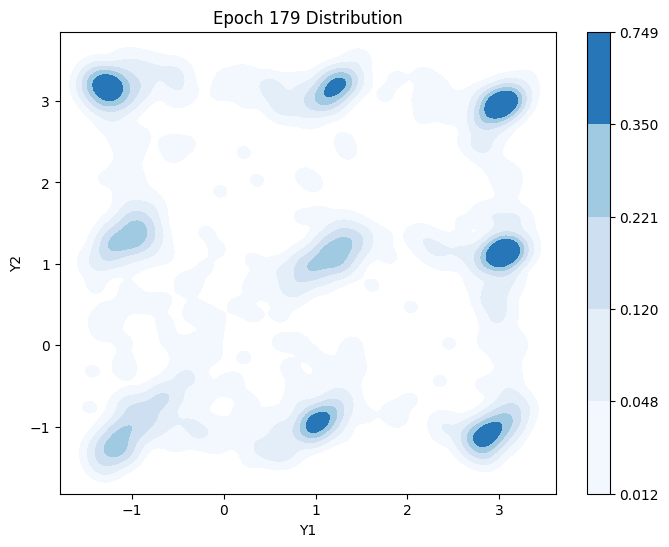

Epoch 179 - D Loss: 0.0157, G Loss: 2.5148
Mean L1 Loss per dimension: tensor([1.4448, 1.4295])
Mean L2 Loss per dimension: tensor([2.8391, 2.7772])
Epoch 180, Iter 7050, D Loss: 0.0129, G Loss: 2.5121, L1: 1.4371, L2: 2.8081
Epoch 180 - D Loss: 0.0143, G Loss: 2.5257
Epoch 181 - D Loss: 0.0133, G Loss: 2.5222
Mean L1 Loss per dimension: tensor([1.4392, 1.4478])
Mean L2 Loss per dimension: tensor([2.8218, 2.7996])
Epoch 182, Iter 7100, D Loss: 0.0050, G Loss: 2.4857, L1: 1.4435, L2: 2.8107
Epoch 182 - D Loss: 0.0157, G Loss: 2.5190
Mean L1 Loss per dimension: tensor([1.4384, 1.4345])
Mean L2 Loss per dimension: tensor([2.8161, 2.7990])
Epoch 183, Iter 7150, D Loss: 0.0141, G Loss: 2.5333, L1: 1.4364, L2: 2.8076
Epoch 183 - D Loss: 0.0124, G Loss: 2.5195
Mean L1 Loss per dimension: tensor([1.4377, 1.4701])
Mean L2 Loss per dimension: tensor([2.8121, 2.9064])
Epoch 184, Iter 7200, D Loss: 0.0161, G Loss: 2.5282, L1: 1.4539, L2: 2.8592


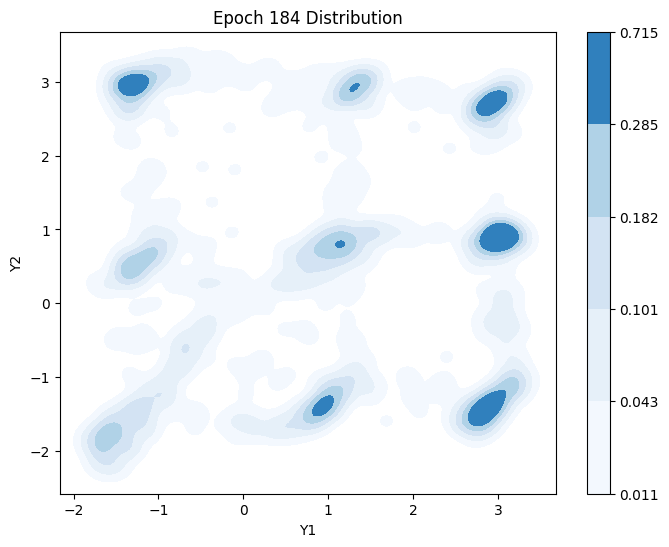

Epoch 184 - D Loss: 0.0156, G Loss: 2.5192
Mean L1 Loss per dimension: tensor([1.4403, 1.4366])
Mean L2 Loss per dimension: tensor([2.8309, 2.7898])
Epoch 185, Iter 7250, D Loss: 0.0148, G Loss: 2.5078, L1: 1.4384, L2: 2.8103
Epoch 185 - D Loss: 0.0152, G Loss: 2.5007
Epoch 186 - D Loss: 0.0136, G Loss: 2.4886
Mean L1 Loss per dimension: tensor([1.4441, 1.4364])
Mean L2 Loss per dimension: tensor([2.8494, 2.8083])
Epoch 187, Iter 7300, D Loss: 0.0177, G Loss: 2.4832, L1: 1.4403, L2: 2.8289
Epoch 187 - D Loss: 0.0141, G Loss: 2.5019
Mean L1 Loss per dimension: tensor([1.4271, 1.4310])
Mean L2 Loss per dimension: tensor([2.8043, 2.7857])
Epoch 188, Iter 7350, D Loss: 0.0190, G Loss: 2.4742, L1: 1.4291, L2: 2.7950
Epoch 188 - D Loss: 0.0159, G Loss: 2.4972
Mean L1 Loss per dimension: tensor([1.4327, 1.4331])
Mean L2 Loss per dimension: tensor([2.8057, 2.7947])
Epoch 189, Iter 7400, D Loss: 0.0144, G Loss: 2.4978, L1: 1.4329, L2: 2.8002


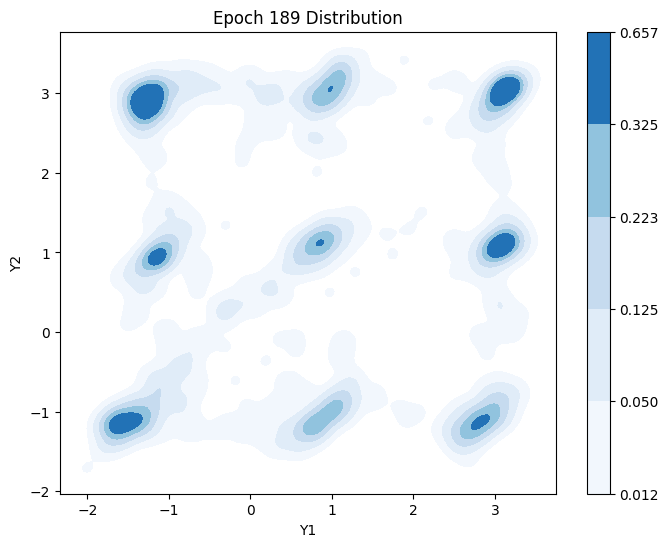

Epoch 189 - D Loss: 0.0130, G Loss: 2.4918
Epoch 190 - D Loss: 0.0156, G Loss: 2.4998
Mean L1 Loss per dimension: tensor([1.4592, 1.4301])
Mean L2 Loss per dimension: tensor([2.8709, 2.7913])
Epoch 191, Iter 7450, D Loss: 0.0086, G Loss: 2.4397, L1: 1.4447, L2: 2.8311
Epoch 191 - D Loss: 0.0141, G Loss: 2.4922
Mean L1 Loss per dimension: tensor([1.4374, 1.4299])
Mean L2 Loss per dimension: tensor([2.8071, 2.7826])
Epoch 192, Iter 7500, D Loss: 0.0108, G Loss: 2.4805, L1: 1.4337, L2: 2.7949
Epoch 192 - D Loss: 0.0128, G Loss: 2.4948
Mean L1 Loss per dimension: tensor([1.4416, 1.4589])
Mean L2 Loss per dimension: tensor([2.8173, 2.8740])
Epoch 193, Iter 7550, D Loss: 0.0132, G Loss: 2.5058, L1: 1.4502, L2: 2.8456
Epoch 193 - D Loss: 0.0132, G Loss: 2.5048
Mean L1 Loss per dimension: tensor([1.4504, 1.4280])
Mean L2 Loss per dimension: tensor([2.8584, 2.7655])
Epoch 194, Iter 7600, D Loss: 0.0133, G Loss: 2.4909, L1: 1.4392, L2: 2.8119


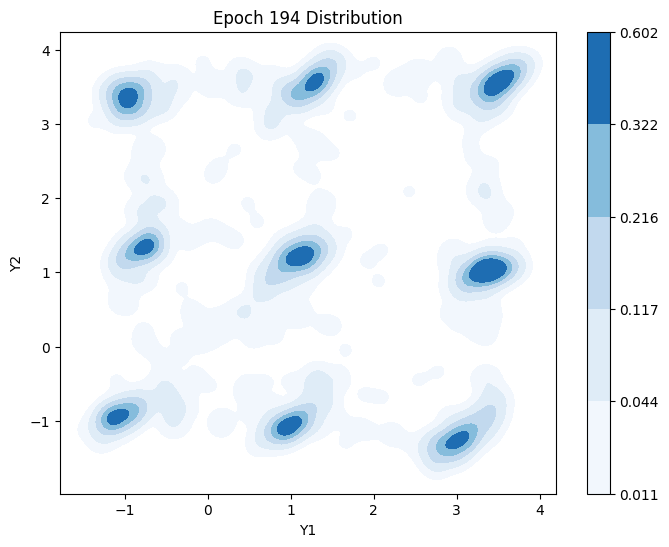

Epoch 194 - D Loss: 0.0142, G Loss: 2.4940
Epoch 195 - D Loss: 0.0137, G Loss: 2.4817
Mean L1 Loss per dimension: tensor([1.4293, 1.4381])
Mean L2 Loss per dimension: tensor([2.7976, 2.8012])
Epoch 196, Iter 7650, D Loss: 0.0254, G Loss: 2.4638, L1: 1.4337, L2: 2.7994
Epoch 196 - D Loss: 0.0162, G Loss: 2.4772
Mean L1 Loss per dimension: tensor([1.4449, 1.4319])
Mean L2 Loss per dimension: tensor([2.8308, 2.7825])
Epoch 197, Iter 7700, D Loss: 0.0128, G Loss: 2.4753, L1: 1.4384, L2: 2.8067
Epoch 197 - D Loss: 0.0112, G Loss: 2.4860
Mean L1 Loss per dimension: tensor([1.4484, 1.4363])
Mean L2 Loss per dimension: tensor([2.8512, 2.7968])
Epoch 198, Iter 7750, D Loss: 0.0159, G Loss: 2.4823, L1: 1.4424, L2: 2.8240
Epoch 198 - D Loss: 0.0142, G Loss: 2.4882
Mean L1 Loss per dimension: tensor([1.4377, 1.4559])
Mean L2 Loss per dimension: tensor([2.8243, 2.8711])
Epoch 199, Iter 7800, D Loss: 0.0132, G Loss: 2.5133, L1: 1.4468, L2: 2.8477


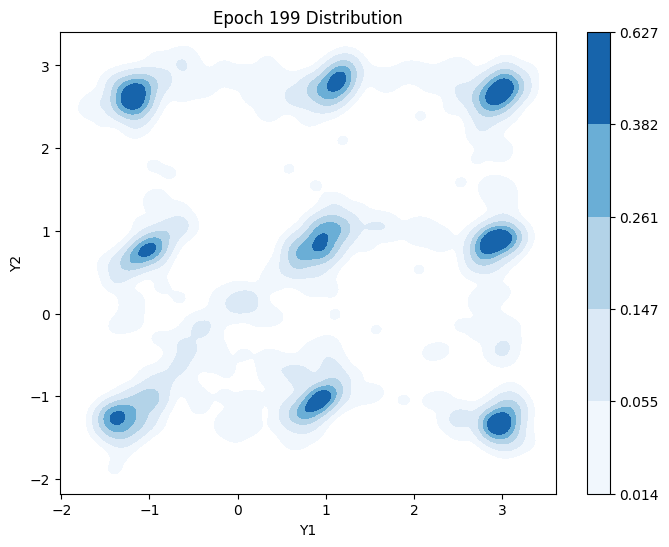

Epoch 199 - D Loss: 0.0132, G Loss: 2.5133
Saved best model with L2: 2.7552


In [10]:
# Training
trained_G, trained_D = train_WGR_fnn(D=D_net, G=G_net, D_solver=D_solver, G_solver=G_solver, 
                                     loader_train = loader_train, loader_val=loader_val,
                                     noise_dim=args.noise_dim, Xdim=args.Xdim, Ydim=args.Ydim, batch_size=args.train_batch,
                                     lambda_w=0.95,lambda_l=0.05, multivariate=True, save_path='./', 
                                     model_type=args.model, device='cpu', num_epochs=200)

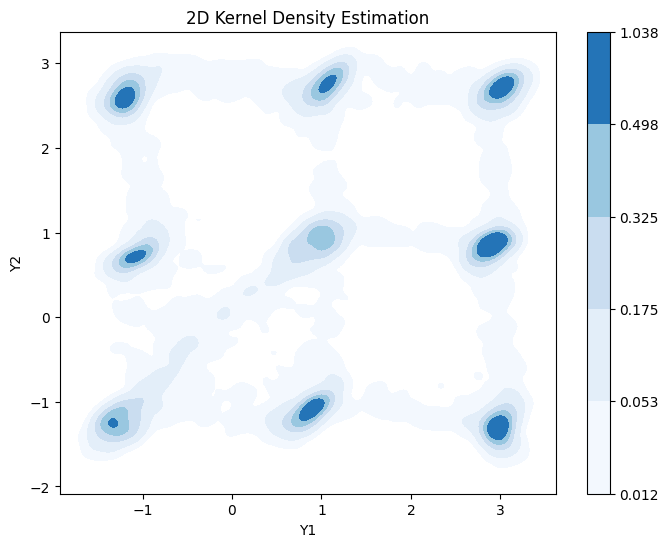

In [11]:
# Visualization for the well-trained generator 
given_X = torch.tensor([[1]]) #condition on X=1 
generate_Y = torch.zeros([10000,2]) #generate 500 response 
for i in range(10000):
    plot_eta = sample_noise(1, dim=args.noise_dim, distribution=args.noise_dist)
    plot_input =  torch.cat([given_X, plot_eta], dim=1)
    generate_Y[i] = trained_G(plot_input)
fig, ax = plot_kde_2d(generate_Y.detach(), title="2D Kernel Density Estimation")
plt.show()
plt.close()    

In [23]:
# Calculate the L1 and L2 error, MSE of conditional mean and conditional standard deviation on the test data  
test_G_mean_sd = L1L2_MSE_mean_sd_G(G = trained_G,  test_size = args.test, noise_dim=args.noise_dim, Xdim=args.Xdim,
                                    batch_size=args.test_batch,  model_type=args.model, loader_dataset = loader_test,
                                    Ydim=args.Ydim,is_multivariate=True )

Model: M3, Multivariate, Ydim: 2, J_t_size: 50
L1 Loss: tensor([2.0773, 2.1404])
L2 Loss: tensor([6.4328, 7.3865])
MSE Mean: tensor([1.8152, 1.1176])
MSE SD: tensor([0.4730, 0.4553])


In [67]:
# Calculate the MSE of conditional quantiles at different levels.
test_G_quantile = MSE_quantile_G_multiY(G = trained_G, loader_dataset = loader_test, Ydim=args.Ydim, Xdim=args.Xdim, 
                                        noise_dim=args.noise_dim,  batch_size=args.test_batch, test_size = args.test, model_type=args.model)

Quantile evaluation for model: M3, Ydim: 2
Quantile 0.05: tensor([0.2347, 0.3348])
Quantile 0.25: tensor([0.1374, 0.1032])
Quantile 0.50: tensor([0.1834, 0.0340])
Quantile 0.75: tensor([0.1180, 0.4702])
Quantile 0.95: tensor([0.1592, 1.2073])
